<h1> <a href = http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/td_3a.html> Eléments logiciels pour le traitement de données massives </a> </h1>
<h2> Theano : kmeans & image segmentation </h2>
<h3> ENSAE - 3A - February 2017 </h3>
<i> Students : Mehdi Miah & Duc-Vinh Tran </i> <br>
<i> Teachers : Xavier Dupré & Mathieu Durut </i>

# Table of contents
1. [Preliminaries](#introduction)
    1. [Imports](#preliminaries)
    2. [Framework](#framework)
2. [Functions definitions](#functions)
    1. [Generation of data](#generationdata)
    2. [Test with naive numpy](#smallnumpy)
    3. [Test with scikit-learn](#smallsklearn)
    4. [Test with Theano](#smalltheano)
        1. [On CPU](#smalltheano_cpu)
        2. [On GPU](#smalltheano_gpu)
3. [Benchmarking](#benchmarking)
    1. [Loading an image a large size image](#loadingimage)
    2. [For a fixed k number and large size image](#k fixed)
    3. [By increasing k number of centroids](#k increasing)
    4. [By increasing the number of points, k fixed](#pointsincreasing)
4. [Conclusion](#conclusion)
    1. [Conclusion on small data](#conclusionsmall)
    1. [Conclusion on big data](#conclusionbig)

# 1 - Preliminaries <a name="preliminaries"></a>

**Introduction : **

The overall layout of this notebook is pretty similar to the previous one, we will keep the functions' definitions for more clarity.
- > The objective here is to evaluate the performance of the different methods:
    - naive approach with numpy
    - theano_cpu only
    - theano_gpu
    - theano_gpu2 (slightly optimized)

## 1.A - Imports <a name="kmeans"></a>

In [1]:
import time
import random
import numpy as np
from math import sqrt
from timeit import default_timer as timer

from matplotlib import pyplot as plt
%matplotlib inline  

import scipy
from scipy import spatial as sp

Kmeans is an unsupervised clustering method. Given a dataset of <i> n_points </i> of dimension <i> n_dim </i>, this algorithm   provide <i> n_clusters </i> new points (centroids) such that each observation belongs to the cluster with the nearest centroids.

This problem can be seen as a optimization problem : given $(z_n)_{n \in [\![1:N]\!]}$ a dataset of $N$ points, one looks for a set $S = \{S_1, ..., S_K\} $ a partition of the data such that it minimizes a cost function $J$ : 
$$ J(S) = \displaystyle \sum \limits_{k=1}^K \sum \limits_{x \in S_k} || x - w_k ||^2,$$
where $w_k$ is the centroid (the mean) of points in the set $S_k$.

This problem is a NP-hard so heuristic algorithms is needed.

In order to solve this problem, one can use gradient descent algorithm which will give a local optimum solution.

For that, the update will be at iteration $t$ : 
$$ w_j^{t+1} := w_j^t - \lambda (w_j^t - z_n),$$
where $w_j^t$ is the closest centroid of $z_n$ at iteration $t$, and $\lambda$ is the learning rate.


In practice, we can use kmeans algorithm to the problem of colour quantization. Given a picture, one want to give the best approximation of this image using only $K$ colours.
In the following example, the picture of the cat is recolored using only 16 colours.

In [2]:
from IPython.display import Image, display

img1 = Image(url='https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png')
img2 = Image(url='https://upload.wikimedia.org/wikipedia/en/4/48/Dithering_example_undithered_16color_palette.png')
display(img1, img2) 

 ## 1.B - Framework <a name="framework"></a>

# 2 - Functions definitions <a name="functions"></a>

In [3]:
# Some parameters we will keep in a context of small data
n_points = 30000 #number of points by clusters(in a plan)
n_clusters = 3 #number of clusters
max_iter = 50 #maximal number of iterations
learning_rate = 0.001 #learning rate in gradient descent
batch_size = 100 #batch size use to accelerate convergence
epsilon = 0.0001 #iterations will be stopped when the cost functions does not change by 0.01% (early stop)

## 2.A - Generation of data <a name="generationdata"></a>

In [4]:
def generate_mixture(n_points):
    ''' Generate a dataset with 2D n_points as a mixture of 3 gaussians'''
    data = np.concatenate([np.random.multivariate_normal([-8,-4], [[1, 0.01], [0.01, 1]], n_points//3),
                        np.random.multivariate_normal([10,7], [[1, 0.01], [0.01, 1]], n_points//3), 
                        np.random.multivariate_normal([4,-2], [[1, 0.01], [0.01, 1]], n_points//3)])
    return(data)

Let's generate some data : 

In [5]:
data = generate_mixture(n_points)

In order to give the final output, one need to implement two functions : the first gives the clusters given the centroids positions and the second function gives the final inertia.

In [6]:
def getClusters_id(data, centroids, n_clusters):
    """
    Returns an array of scalars (1:n_clusters) of dimension nb_points.
    """
    clusters= [None]*np.shape(data)[0]
    for i,x in enumerate(data):
        clusters[i] = min(range(n_clusters), key=lambda j: np.sqrt(((data[i]-centroids[j])**2).sum(axis=0)))
    return clusters

In [7]:
def getInertia(data, centroids):
    '''
    Returns the sum of distance between each points of data and
    the nearest centroids
    '''
    #get the number of n_clusters
    n_clusters = centroids.shape[0]
    
    #get the clusters for each points
    clusters = getClusters_id(data, centroids, n_clusters)
    
    #get the nearest centroid for each point
    centroids_all_points = data.copy()
    for i,x in enumerate(data):
        centroids_all_points[i] = centroids[clusters[i]]
        
    #compute the inertia 
    distance = np.sum(np.square(data - centroids_all_points))
    
    return distance

## 2.B - Test with naive numpy <a name="smallnumpy"></a>

In [8]:
def kmeans_naive_numpy(X, n_clusters, max_iter=100, epsilon = 0.01):
    '''
    Returns a clustering using combinatory optimisation and not gradient descent
    '''
    start_time = time.time()
    # Initialize from random points.
    centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), n_clusters)])
    clusters = [None] * np.shape(X)[0]
    old_centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), n_clusters)]) #beware !
    ''' Beware : a better initialization ?'''
    
    n_iter = 1
     
    while (n_iter <= max_iter) & (np.linalg.norm(centers - old_centers) > epsilon):
        for i, x in enumerate(X):
            clusters[i] = min(range(n_clusters), key=lambda j: np.linalg.norm(np.array(x) - np.array(centers[j])))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if clusters[i] == j]
            old_centers = centers.copy()
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
            
        n_iter += 1    
    return clusters, np.array(centers), n_iter,time.time()-start_time


One notices that, sometimes, these clusters are not the best one. Indeed, given the fact that this problem is not convex, the solution is not the global minimizer.

## 2.C - Test with scikit-learn <a name="smallsklearn"></a>

In [9]:
from sklearn.cluster import MiniBatchKMeans

def kmeans_sklearn(X,n_clusters,init='k-means++', max_iter=max_iter, batch_size=batch_size,verbose=False):
    start_time = time.time()
    centroids_small_sklearn = MiniBatchKMeans(n_clusters, init='k-means++', max_iter=max_iter, batch_size=batch_size,
                                              verbose=False).fit(X)
    time_small_sklearn = time.time() - start_time

    return centroids_small_sklearn.cluster_centers_, time_small_sklearn

## 2.D - Test with Theano <a name="smalltheano"></a>

### 2.D.a - on CPU <a name="smalltheano_cpu"></a>

In [10]:
import theano
from theano import tensor as T
from theano import function, config, shared, sandbox, Out

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [11]:
def kmeans_theano_cpu(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.dmatrix('Z') #represents the data, size n_points x n_dim
    W = T.dmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim), name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.mul(T.sum(W,axis = 0)[:,None], centroids) - T.dot(W.T, Z)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids - learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN")
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, mode="FAST_RUN")
    
    start_time = time.time()
    #check if GPU usage
    #if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        #print('Used the CPU')
    #else:
        #print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #keep the cost function with regards to iterations
    old_cost = 2
    new_cost = 1
    n_iter = 0
    
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        filename = 'temp.dat'
        fp = np.memmap(filename, dtype=int, mode='w+', shape=np.shape(data)[0])
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])
            fp[i:i+batch_size]=clusters[:] #storing in disk
            #arr += np.lib.pad(clusters, (i,len(arr)-batch_size-i), 'constant', constant_values=(0, 0))
            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        n_iter += 1    

    return centroids.get_value(),time.time()-start_time

**Note :** The CPU version of the algorithm will right on disk the updated centroids, as for here, it impacts little the overall performances as it is not used/loaded in memory. It will be used later in order to reconstruct the picture.

### 2.D.b - on GPU <a name="smalltheano_gpu"></a>

**Warning : ** All floats are casted as float32 for Cuda.

In [12]:
def kmeans_theano_gpu(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variable
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    #np.random.seed(42)
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX), name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.mul(T.sum(W,axis = 0)[:,None], centroids) - T.dot(W.T, Z)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids - learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update,
                                       allow_input_downcast=True,mode="FAST_RUN")
    star_time = time.time()
    #check if GPU usage
    #if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        #print('Used the CPU')
    #else:
        #print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #keep the cost function with regards to iterations
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        n_iter += 1    

    return centroids.get_value(),time.time()-star_time

In [13]:
def kmeans_theano_gpu2(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variable
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    #np.random.seed(42)
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX),
                              borrow=True, name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2.*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.mul(T.sum(W,axis = 0)[:,None], centroids) - T.dot(W.T, Z)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids - learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z],
                                      outputs = clusters,
                                      mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W],
                                       outputs = Out(sandbox.cuda.basic_ops.gpu_from_host(errors),borrow=True),
                                       updates = update,
                                       allow_input_downcast=True,mode="FAST_RUN")
    start_time = time.time()
    #check if GPU usage
    #if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        #print('Used the CPU')
    #else:
        #print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #keep the cost function with regards to iterations
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        n_iter += 1    

    return centroids.get_value(),time.time()-start_time

# 3 - Benchmarking <a name="benchmarking"></a>

Given the results on small data, it is sufficient to compare scikit-learn and Theano methods.

In [14]:
# Some parameters we will keep in a context of big data

n_clusters = 256 #number of clusters
max_iter = 100 #maximal number of iterations
learning_rate = 0.001 #learning rate in gradient descent
epsilon = 0.0001 #iterations will be stopped when the cost functions does not change by 0.01% (early stop)

## 3.A - Loading an image a large size image <a name="loadingimage"></a>

Image size : [1080, 1920, 3]
Data size : [2073600, 3]
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 316 ms


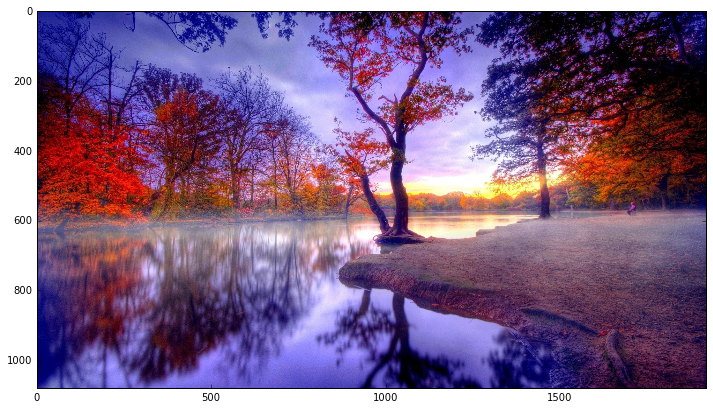

In [15]:
%%time
image = scipy.misc.imread('../data/images/beautiful-01.jpg')
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
my_image = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])

print('Image size : %s' %(list(np.shape(image))) )
print('Data size : %s' %(list(np.shape(my_image))) ) #the image is flatten over the third dimension

#store for batch size:
batch_size = max(np.shape(image))

#delete the initial image
del image

### 3.A.a. For a fixed k number and large size image<a name="k fixed"></a>

** 2 Millions of pixels, 256 centroids**

In [ ]:
%%time
centroids_big_theano_cpu,t_cpu = kmeans_theano_cpu(my_image,n_clusters, learning_rate, max_iter, batch_size,
                                                   epsilon,verbose=False)

centroids_big_theano_gpu,t_gpu= kmeans_theano_gpu(my_image,n_clusters,learning_rate, max_iter, batch_size, epsilon,
                                             verbose=False)

centroids_big_theano_gpu2,t_gpu2 = kmeans_theano_gpu2(my_image, n_clusters, learning_rate, max_iter, batch_size,
                                                     epsilon,verbose=False)

centroids_big_sklearn,t_sklearn = kmeans_sklearn(my_image,n_clusters,init='k-means++', max_iter=max_iter,
                                                     batch_size=batch_size,verbose=False)

#t_np_naive = kmeans_naive_numpy(my_image, n_clusters, max_iter=100, epsilon = 0.01)[3] #takes a lot of time

In [20]:
%%time

centroids_big_sklearn,t_sklearn = kmeans_sklearn(my_image,n_clusters,init='k-means++', max_iter=max_iter,
                                                     batch_size=batch_size,verbose=False)

CPU times: user 34.4 s, sys: 1min 44s, total: 2min 18s
Wall time: 17.9 s


** WARNING Naive Numpy approach is from far inefficient in term of time, we won't keep it for further computations...**

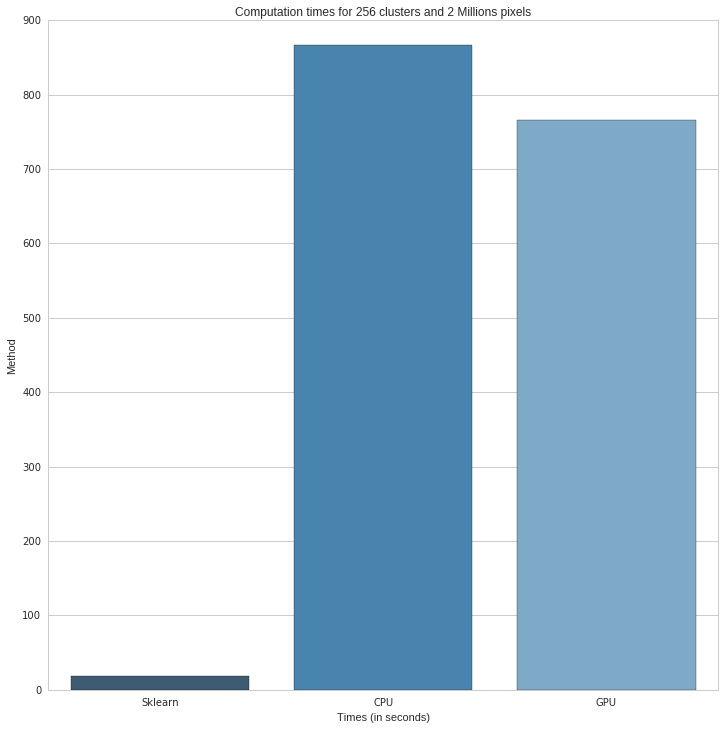

In [28]:
import seaborn as sns

v = ['Sklearn', 'CPU', 'GPU']
w = [t_sklearn,t_cpu,t_gpu]

plt.figure(figsize=(12,12))
sns.set_style("whitegrid")
ax = sns.barplot(x=v, y=w, palette='Blues_d')
ax.set(xlabel="Times (in seconds)", ylabel="Method")
ax.set_title('Computation times for 256 clusters and 2 Millions pixels')

Sklearn mini-bacthed Kmeans implementation still bit us from far...

### 3.A.b. By increasing k number of centroids<a name="k increasing"></a>

Image size : [432, 640, 4]
Data size : [276480, 3]
CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 56.6 ms


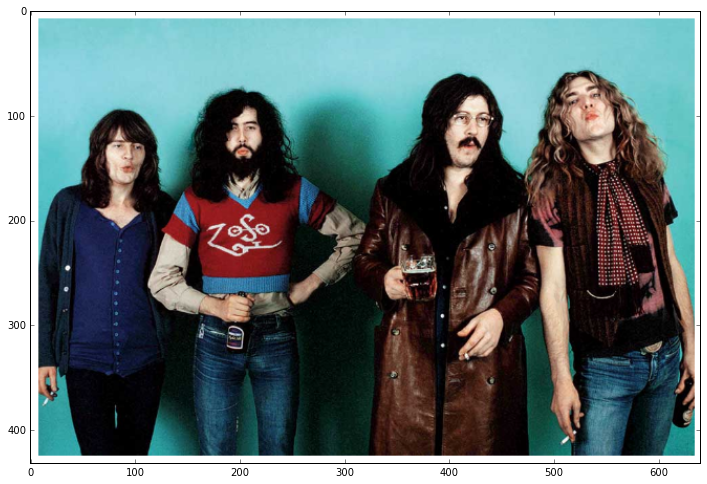

In [22]:
%%time
image = scipy.misc.imread('../data/images/orig.png')
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
my_image = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])

print('Image size : %s' %(list(np.shape(image))) )
print('Data size : %s' %(list(np.shape(my_image))) ) #the image is flatten over the third dimension

#store for batch size:
batch_size = max(np.shape(image))

#delete the initial image
del image

In [23]:
%%time
l_cpu=[]
l_gpu=[]
l_gpu2=[]
l_sk=[]
l_naive=[]
axis_=[x*x for x in range(17)]
for k in axis_:
    centroids_big_theano_cpu,t_cpu = kmeans_theano_cpu(my_image,k+1, learning_rate, max_iter, batch_size,
                                                       epsilon,verbose=False)

    centroids_big_theano_gpu,t_gpu= kmeans_theano_gpu(my_image,k+1,learning_rate, max_iter, batch_size, epsilon,
                                                 verbose=False)

    centroids_big_theano_gpu2,t_gpu2 = kmeans_theano_gpu2(my_image, k+1, learning_rate, max_iter, batch_size,
                                                         epsilon,verbose=False)

    centroids_big_sklearn,t_sklearn = kmeans_sklearn(my_image,k+1,init='k-means++', max_iter=max_iter,
                                                         batch_size=batch_size,verbose=False)

    #t_np_naive = kmeans_naive_numpy(my_image, k, max_iter=100, epsilon = 0.01)[3]
    
    l_cpu.append(t_cpu)
    l_gpu.append(t_gpu)
    l_gpu2.append(t_gpu2)
    l_sk.append(t_sklearn)
    #l_naive.append(t_np_naive)

CPU times: user 6min 47s, sys: 8min 55s, total: 15min 43s
Wall time: 5min 58s


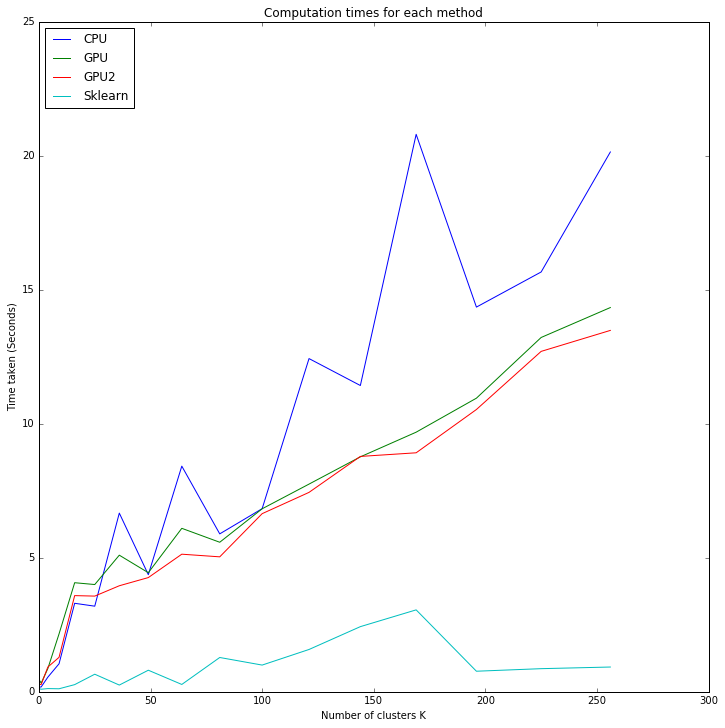

In [24]:
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.plot(axis_, l_cpu)
plt.plot(axis_, l_gpu)
plt.plot(axis_, l_gpu2)
plt.plot(axis_, l_sk)
#plt.plot(axis_, l_naive)

plt.legend(['CPU', 'GPU', 'GPU2', 'Sklearn'], loc='upper left')
plt.title("Computation times for each method")
plt.xlabel("Number of clusters K")
plt.ylabel("Time taken (Seconds)")
plt.show()

### 3.A.c. By increasing the number of points, k fixed<a name="pointsincreasing"></a>

In [19]:
%%time
l_cpu=[]
l_gpu=[]
l_gpu2=[]
l_sk=[]
#l_naive=[]
k=3
batch_size=3000
axis_=[300*(10**x) for x in range(1,6)]
for n_points in axis_:
    data = generate_mixture(n_points)
    centroids_big_theano_cpu,t_cpu = kmeans_theano_cpu(data,k, learning_rate, max_iter, batch_size,
                                                       epsilon,verbose=False)

    centroids_big_theano_gpu,t_gpu= kmeans_theano_gpu(data,k,learning_rate, max_iter, batch_size, epsilon,
                                                 verbose=False)

    centroids_big_theano_gpu2,t_gpu2 = kmeans_theano_gpu2(data, k, learning_rate, max_iter, batch_size,
                                                         epsilon,verbose=False)

    centroids_big_sklearn,t_sklearn = kmeans_sklearn(data,k,init='k-means++', max_iter=max_iter,
                                                         batch_size=batch_size,verbose=False)

    #t_np_naive = kmeans_naive_numpy(my_image, k, max_iter=100, epsilon = 0.01)[3]
    
    l_cpu.append(t_cpu)
    l_gpu.append(t_gpu)
    l_gpu2.append(t_gpu2)
    l_sk.append(t_sklearn)
    #l_naive.append(t_np_naive)


CPU times: user 54.9 s, sys: 10.9 s, total: 1min 5s
Wall time: 1min 11s


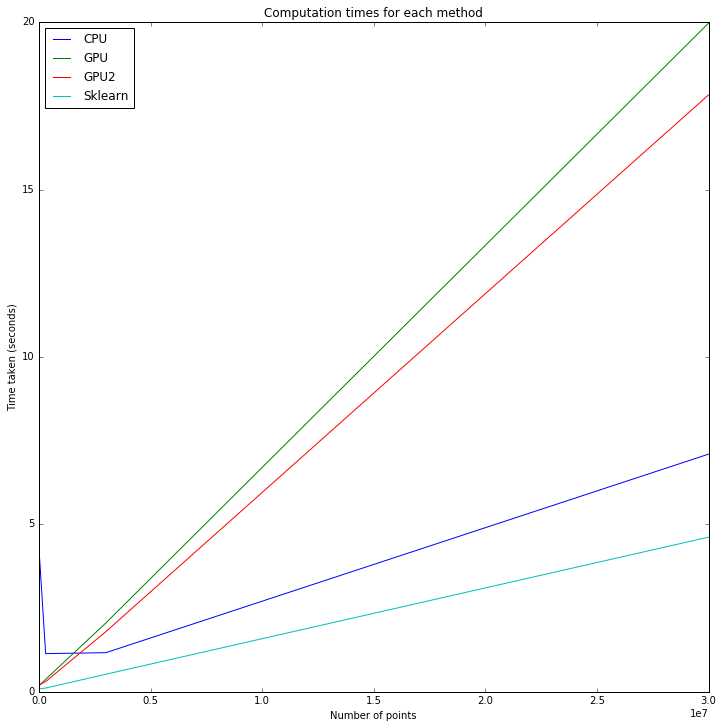

In [20]:
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.plot(axis_, l_cpu)
plt.plot(axis_, l_gpu)
plt.plot(axis_, l_gpu2)
plt.plot(axis_, l_sk)
#plt.plot(axis_, l_naive)

plt.legend(['CPU', 'GPU', 'GPU2', 'Sklearn'], loc='upper left')
plt.title("Computation times for each method")
plt.xlabel("Number of points")
plt.ylabel("Time taken (seconds)")
plt.show()

# 4 - Conclusion <a name="conclusion"></a>

The GPU speedup is more relevant for large k centroids number 23s(CPU) vs 15s(GPU), however for large number of point and small number of clusters, the CPU version does perform better. The reason behind this is because of :
- > update_clusters which seems to not be optimised correctly for GPU usage. On the opposite of the more simple function of update_centroids wich does perform well on GPU hence the inscrease in speed for large number of centroids